# Chapter 5. Spark SQL and DataFrames - Interacting with External Data Sources

https://learning.oreilly.com/library/view/learning-spark-2nd/9781492050032/ch05.html

# Setup

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from pyspark import SparkContext

sc = SparkContext('local', 'Ch5')

In [3]:
from pyspark.sql import SparkSession

# create a SparkSession
spark = (SparkSession
    .builder
    .appName("ch5 example")
    .getOrCreate())

In [4]:
spark

In [5]:
sc

<SparkContext master=local appName=Ch5>

# Imports

In [6]:
import os

# Spark SQL UDFs

* UDFs operate per session and they will not be persisted in the underlying metastore.

In [7]:
from pyspark.sql.types import LongType

In [8]:
# create cubed function
def cubed(s):
    return s * s * s

In [13]:
# register UDF
# spark.udf.register(name, f, returnType)
spark.udf.register('c3', cubed, LongType())

<function __main__.cubed(s)>

In [10]:
spark.range(1,9).show()

+---+
| id|
+---+
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
+---+



In [11]:
# generate temporary view
spark.range(1, 9).createOrReplaceTempView('udf_test')

In [14]:
# Execute cubed function

spark.sql("""
select 
    id,
    c3(id) as id_cubed
from udf_test
    """).show()

+---+--------+
| id|id_cubed|
+---+--------+
|  1|       1|
|  2|       8|
|  3|      27|
|  4|      64|
|  5|     125|
|  6|     216|
|  7|     343|
|  8|     512|
+---+--------+



# pyspark udfs with pandas udfs

3 types of pandas UDFS

* scalar
* grouped map
* grouped aggregate

## Scalar pandas UDFs

In [15]:
import pandas as pd

from pyspark.sql.functions import col, pandas_udf

In [16]:
from pyspark.sql.types import LongType

In [17]:
# Declare cubed function

def cubed(a: pd.Series) -> pd.Series:
    return a * a * a

In [19]:
cubed(pd.Series([1,2,3,4]))

0     1
1     8
2    27
3    64
dtype: int64

In [20]:
# Create pandas UDF

cubed_udf = pandas_udf(cubed, returnType=LongType())

In [21]:
# Create pandas series

x = pd.Series([1, 2, 3])

# function for a pandas_udf executed with a pandas df
print(cubed(x))

0     1
1     8
2    27
dtype: int64


In [22]:
cubed(x)

0     1
1     8
2    27
dtype: int64

In [28]:
(pd.DataFrame(data=[1,2,3], columns=['a'])
   .assign(b=lambda x: cubed(x['a'])))

,a,b
0,1,1
1,2,8
2,3,27


In [29]:
from pyspark.sql.functions import col

The following fails due to no `pyarrow`

In [32]:
# create a spark data frame

df = spark.range(1, 4)

# execute function as a spark vectorized UDF

df.select('id', cubed_udf(col('id'))).show()

Py4JJavaError: An error occurred while calling o91.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 5.0 failed 1 times, most recent failure: Lost task 0.0 in stage 5.0 (TID 5, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 366, in main
    func, profiler, deserializer, serializer = read_udfs(pickleSer, infile, eval_type)
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 241, in read_udfs
    arg_offsets, udf = read_single_udf(pickleSer, infile, eval_type, runner_conf)
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 180, in read_single_udf
    return arg_offsets, wrap_scalar_pandas_udf(func, return_type)
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 89, in wrap_scalar_pandas_udf
    arrow_return_type = to_arrow_type(return_type)
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/sql/types.py", line 1585, in to_arrow_type
    import pyarrow as pa
ModuleNotFoundError: No module named 'pyarrow'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec$$anon$2.<init>(ArrowEvalPythonExec.scala:98)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:96)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:127)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:89)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3389)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:80)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:127)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:75)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2764)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 366, in main
    func, profiler, deserializer, serializer = read_udfs(pickleSer, infile, eval_type)
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 241, in read_udfs
    arg_offsets, udf = read_single_udf(pickleSer, infile, eval_type, runner_conf)
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 180, in read_single_udf
    return arg_offsets, wrap_scalar_pandas_udf(func, return_type)
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 89, in wrap_scalar_pandas_udf
    arrow_return_type = to_arrow_type(return_type)
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/sql/types.py", line 1585, in to_arrow_type
    import pyarrow as pa
ModuleNotFoundError: No module named 'pyarrow'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec$$anon$2.<init>(ArrowEvalPythonExec.scala:98)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:96)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:127)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:89)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [33]:
!python -m pip freeze | grep arrow

pyarrow==0.14.1


## This is failing

org.apache.arrow errors

* may only work in spark 3.x
    * https://spark.apache.org/docs/2.4.5/sql-pyspark-pandas-with-arrow.html
    
* the way mentioned above still works

Solution

* downgrade pyarrow to < 0.15.0
* https://stackoverflow.com/questions/58269115/how-to-enable-apache-arrow-in-pyspark/58273294#58273294

In [22]:
spark.version

'2.4.5'

In [40]:
df.select('id', cubed_udf(col('id'))).show()

AnalysisException: "cannot resolve '`id`' given input columns: [0, 1, 2];;\n'Project ['id, cubed('id) AS cubed(id)#89]\n+- LogicalRDD [0#72, 1#73, 2#74], false\n"

### tweaks for apache arrow

https://spark.apache.org/docs/2.4.5/sql-pyspark-pandas-with-arrow.html

In [35]:
import numpy as np
import pandas as pd

In [36]:
# enable Arrow-based columnar data transfers
spark.conf.set('spark.sql.exection.arrow.enabled', 'true')

In [37]:
# generate a pandas df
p_df = pd.DataFrame(np.random.rand(100, 3))

In [38]:
# create a spark df from pandas df using arrow
df = spark.createDataFrame(p_df)

In [39]:
df.show(4)

+-------------------+-------------------+------------------+
|                  0|                  1|                 2|
+-------------------+-------------------+------------------+
| 0.6383238735266533| 0.1229324250482483|0.5004332379710518|
| 0.8893595760441708| 0.8014836248561271|0.4678772283740127|
|0.10227968236981688|0.27089872329109077|0.8411819410689203|
|0.14010343920436386| 0.9105133058566349|0.5080238479877998|
+-------------------+-------------------+------------------+
only showing top 4 rows



In [41]:
# convert the spark df back to a pandas df using arrow
result_pdf = df.select('*').toPandas()
result_pdf

,0,1,2
0,0.638324,0.122932,0.500433
1,0.889360,0.801484,0.467877
2,0.102280,0.270899,0.841182
3,0.140103,0.910513,0.508024
4,0.530893,0.322366,0.132806
...,...,...,...
95,0.936583,0.906822,0.390441
96,0.444233,0.225015,0.181203
97,0.569095,0.117613,0.316104
98,0.268338,0.248115,0.130151


### pandas UDFs (a.k.a. vectorized UDFs)

https://spark.apache.org/docs/2.4.5/sql-pyspark-pandas-with-arrow.html

In [42]:
import pandas as pd

from pyspark.sql.functions import col, pandas_udf
from pyspark.sql.types import LongType

# declare the functiom and create UDF
def multiply_func(a, b):
    return a * b

multiply = pandas_udf(multiply_func, returnType=LongType())

In [43]:
# the function for a pandas udf should be able to execute wit local pandas data
x = pd.Series([1, 2, 3])

print(multiply_func(x, x))

0    1
1    4
2    9
dtype: int64


In [44]:
# create a spark df
df = spark.createDataFrame(pd.DataFrame(x, columns=['x']))

In [45]:
df.show()

+---+
|  x|
+---+
|  1|
|  2|
|  3|
+---+



In [46]:
# execute the function as a spark vectorized udf
df.select(multiply(col('x'), col('x'))).show()

Py4JJavaError: An error occurred while calling o319.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 10.0 failed 1 times, most recent failure: Lost task 0.0 in stage 10.0 (TID 10, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 366, in main
    func, profiler, deserializer, serializer = read_udfs(pickleSer, infile, eval_type)
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 241, in read_udfs
    arg_offsets, udf = read_single_udf(pickleSer, infile, eval_type, runner_conf)
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 180, in read_single_udf
    return arg_offsets, wrap_scalar_pandas_udf(func, return_type)
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 89, in wrap_scalar_pandas_udf
    arrow_return_type = to_arrow_type(return_type)
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/sql/types.py", line 1585, in to_arrow_type
    import pyarrow as pa
ModuleNotFoundError: No module named 'pyarrow'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec$$anon$2.<init>(ArrowEvalPythonExec.scala:98)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:96)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:127)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:89)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3389)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:80)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:127)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:75)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2764)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 366, in main
    func, profiler, deserializer, serializer = read_udfs(pickleSer, infile, eval_type)
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 241, in read_udfs
    arg_offsets, udf = read_single_udf(pickleSer, infile, eval_type, runner_conf)
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 180, in read_single_udf
    return arg_offsets, wrap_scalar_pandas_udf(func, return_type)
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 89, in wrap_scalar_pandas_udf
    arrow_return_type = to_arrow_type(return_type)
  File "/Users/bartev/dev/spark-2.4.5-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/sql/types.py", line 1585, in to_arrow_type
    import pyarrow as pa
ModuleNotFoundError: No module named 'pyarrow'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec$$anon$2.<init>(ArrowEvalPythonExec.scala:98)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:96)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:127)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:89)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


## grouped map (pandas udf)

https://spark.apache.org/docs/2.4.5/sql-pyspark-pandas-with-arrow.html

Must define

* A Python function that defines the computation for each group.
* A StructType object or a string that defines the schema of the output DataFrame.


In [36]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

df = spark.createDataFrame(
    [(1, 1.0), (1, 2.0), (2, 3.0), (2, 5.0), (2, 10.0)],
    ("id", "v"))
df.show()

+---+----+
| id|   v|
+---+----+
|  1| 1.0|
|  1| 2.0|
|  2| 3.0|
|  2| 5.0|
|  2|10.0|
+---+----+



In [37]:
# function to apply to each group

@pandas_udf("id long, v double", PandasUDFType.GROUPED_MAP)
def subtract_mean(pdf):
    # pdf is a pandas.DataFrame
    v = pdf.v
    return pdf.assign(v=v - v.mean())

df.groupby("id").apply(subtract_mean).show()

+---+----+
| id|   v|
+---+----+
|  1|-0.5|
|  1| 0.5|
|  2|-3.0|
|  2|-1.0|
|  2| 4.0|
+---+----+



# Higher-Order Functions

In [50]:
spark

In [53]:
from pyspark.sql.types import *

In [56]:
schema = StructType(
    [StructField("celsius", ArrayType(IntegerType()))])

t_list = [[35, 36, 32, 30, 40, 42, 38]], [[31, 32, 34, 55, 56]]

t_list

([[35, 36, 32, 30, 40, 42, 38]], [[31, 32, 34, 55, 56]])

In [58]:
t_c = spark.createDataFrame(t_list, schema)

t_c.createOrReplaceTempView("tC")

# Show the DataFrame
t_c.show()

+--------------------+
|             celsius|
+--------------------+
|[35, 36, 32, 30, ...|
|[31, 32, 34, 55, 56]|
+--------------------+



## Transform

```
transform(array<T>, function<T, U>): array<U>
```

In [59]:
# Calculate Fahrenheit from Celsius for an array of temperatures

In [61]:
spark.sql("select * from tc").show()

+--------------------+
|             celsius|
+--------------------+
|[35, 36, 32, 30, ...|
|[31, 32, 34, 55, 56]|
+--------------------+



In [62]:
spark.sql("""
SELECT celsius
  FROM tC
""").show()

+--------------------+
|             celsius|
+--------------------+
|[35, 36, 32, 30, ...|
|[31, 32, 34, 55, 56]|
+--------------------+



In [65]:
spark.sql("""
SELECT celsius, 
 transform(celsius, t -> ((t * 9) div 5) + 32) as fahrenheit
  FROM tC
""").show()

+--------------------+--------------------+
|             celsius|          fahrenheit|
+--------------------+--------------------+
|[35, 36, 32, 30, ...|[95, 96, 89, 86, ...|
|[31, 32, 34, 55, 56]|[87, 89, 93, 131,...|
+--------------------+--------------------+



## Filter 

In [81]:
# filter temperatures > 38C for array of teperatures

spark.sql("""
select celsius,
filter(celsius, t -> t > 38) as high
from tC
""").show()

+--------------------+--------+
|             celsius|    high|
+--------------------+--------+
|[35, 36, 32, 30, ...|[40, 42]|
|[31, 32, 34, 55, 56]|[55, 56]|
+--------------------+--------+



In [67]:
# filter temperatures > 38C for array of teperatures

spark.sql("""
select celsius,
filter(celsius, t -> t > 38) as high
from tC
""").show()

+--------------------+--------+
|             celsius|    high|
+--------------------+--------+
|[35, 36, 32, 30, ...|[40, 42]|
|[31, 32, 34, 55, 56]|[55, 56]|
+--------------------+--------+



In [68]:
# this won't work

# filter temperatures > 38C for array of teperatures

spark.sql("""
select celsius,
filter(celsius, t -> t > 38) as high,
transform(high, t -> ((t * 9) div 5) + 32) as high_f
from tC
""").show()

AnalysisException: "cannot resolve '`high`' given input columns: [tc.celsius]; line 4 pos 10;\n'Project [celsius#113, filter(celsius#113, lambdafunction((lambda t#173 > 38), lambda t#173, false)) AS high#171, 'transform('high, lambdafunction((cast(((lambda 't * 9) / 5) as bigint) + 32), lambda 't, false)) AS high_f#172]\n+- SubqueryAlias `tc`\n   +- LogicalRDD [celsius#113], false\n"

### Multiple steps

In [69]:
# filter temperatures > 38C for array of teperatures

spark.sql("""
with step1 as (
    select celsius,
    transform(celsius, t -> ((t * 9) div 5) + 32) as farenheit,
    filter(celsius, t -> t > 38) as high
    from tC)
select *,
    transform(high, t -> ((t * 9) div 5) + 32) as high_f
from step1
""").show()

+--------------------+--------------------+--------+----------+
|             celsius|           farenheit|    high|    high_f|
+--------------------+--------------------+--------+----------+
|[35, 36, 32, 30, ...|[95, 96, 89, 86, ...|[40, 42]|[104, 107]|
|[31, 32, 34, 55, 56]|[87, 89, 93, 131,...|[55, 56]|[131, 132]|
+--------------------+--------------------+--------+----------+



## Exists

```
exists(array<T>, function<T, V, Boolean>): Boolean
```

The exists function returns true if the boolean function holds for any element in the input array.



In [70]:
# Is there a temperature of 38C in the array of temperatures

spark.sql("""
select 
    celsius,
    exists(celsius, t -> t = 38) as threshold
from tC
""").show()

+--------------------+---------+
|             celsius|threshold|
+--------------------+---------+
|[35, 36, 32, 30, ...|     true|
|[31, 32, 34, 55, 56]|    false|
+--------------------+---------+



## Reduce

```
reduce(array<T>, B, function<B, T, B>, function<B, R>)
```

The reduce function reduces the elements of the array to a single value by merging the elements into a buffer B using function<B, T, B> and by applying a finishing function<B, R> on the final buffer.



In [72]:
from pyspark.sql.functions import reduce

ImportError: cannot import name 'reduce' from 'pyspark.sql.functions' (/Users/bartev/.venvs3/lrnpyspark/lib/python3.7/site-packages/pyspark/sql/functions.py)

In [73]:
#  Calculate average temperature and convert to F

spark.sql("""
SELECT celsius, 
       reduce(
          celsius, 
          0, 
          (t, acc) -> t + acc, 
          acc -> (acc div size(celsius) * 9 div 5) + 32
        ) as avgFahrenheit 
  FROM tC
""").show()


AnalysisException: "Undefined function: 'reduce'. This function is neither a registered temporary function nor a permanent function registered in the database 'default'.; line 3 pos 7"

# Dataframs and Spark SQl common relational operators

## Create a `transform` (`pipe`) operator for DataFrames

In [84]:
import pyspark

from pyspark.sql.dataframe import DataFrame

def transform(self, f):
    return f(self)

DataFrame.transform = transform

## Import 2 files and create 2 DFs - airport info and delays

In [87]:
data_dir = os.path.expanduser('~/dev/data/airline-kaggle')
fn_flights = os.path.join(data_dir, 'flights.csv')
fn_airlines = os.path.join(data_dir, 'airlines.csv')
fn_airports = os.path.join(data_dir, 'airports.csv')

In [75]:
def lcase_cols(df):
    """return a new DataFrame with all columns lower cased"""
    return df.toDF(*[c.lower() for c in df.columns])

In [131]:
airlines = (spark
 .read
 .format('csv')
 .option('inferSchema', True)
 .option('header', True)
 .csv(fn_airlines)
 .transform(lcase_cols)
            .withColumnRenamed('iata_code', 'iata')
)

airlines.createOrReplaceTempView('airlines')

In [132]:
spark.sql('select * from airlines limit 10').show()

+----+--------------------+
|iata|             airline|
+----+--------------------+
|  UA|United Air Lines ...|
|  AA|American Airlines...|
|  US|     US Airways Inc.|
|  F9|Frontier Airlines...|
|  B6|     JetBlue Airways|
|  OO|Skywest Airlines ...|
|  AS|Alaska Airlines Inc.|
|  NK|    Spirit Air Lines|
|  WN|Southwest Airline...|
|  DL|Delta Air Lines Inc.|
+----+--------------------+



In [124]:
airports = (spark
 .read
 .format('csv')
 .option('inferSchema', True)
 .option('header', True)
 .csv(fn_airports)
 .transform(lcase_cols)
            .withColumnRenamed('iata_code', 'iata')
            .drop('latitude', 'longitude')
)

airports.createOrReplaceTempView('airports')

In [129]:
spark.sql('select * from airports limit 10').show()

+----+--------------------+-------------+-----+-------+
|iata|             airport|         city|state|country|
+----+--------------------+-------------+-----+-------+
| ABE|Lehigh Valley Int...|    Allentown|   PA|    USA|
| ABI|Abilene Regional ...|      Abilene|   TX|    USA|
| ABQ|Albuquerque Inter...|  Albuquerque|   NM|    USA|
| ABR|Aberdeen Regional...|     Aberdeen|   SD|    USA|
| ABY|Southwest Georgia...|       Albany|   GA|    USA|
| ACK|Nantucket Memoria...|    Nantucket|   MA|    USA|
| ACT|Waco Regional Air...|         Waco|   TX|    USA|
| ACV|      Arcata Airport|Arcata/Eureka|   CA|    USA|
| ACY|Atlantic City Int...|Atlantic City|   NJ|    USA|
| ADK|        Adak Airport|         Adak|   AK|    USA|
+----+--------------------+-------------+-----+-------+



In [93]:
flights = (spark
 .read
 .format('csv')
 .option('samplingRatio', 0.01)
 .option('inferSchema', True)
 .option('header', True)
 .csv(fn_flights)
 .transform(lcase_cols)
)

flights.createOrReplaceTempView('flights')

In [133]:
departure_delays = (
    flights
    .withColumnRenamed('origin_airport', 'origin')
    .withColumnRenamed('destination_airport', 'destination')
    .withColumnRenamed('departure_delay', 'dep_delay')
    .withColumnRenamed('arrival_delay', 'delay')
    .select('year', 'month', 'day', 'delay', 'distance', 
            'origin', 'destination')
)

departure_delays.createOrReplaceTempView('departureDelays')

In [134]:
spark.sql('select * from departureDelays limit 10').show()

+----+-----+---+-----+--------+------+-----------+
|year|month|day|delay|distance|origin|destination|
+----+-----+---+-----+--------+------+-----------+
|2015|    1|  1|  -22|    1448|   ANC|        SEA|
|2015|    1|  1|   -9|    2330|   LAX|        PBI|
|2015|    1|  1|    5|    2296|   SFO|        CLT|
|2015|    1|  1|   -9|    2342|   LAX|        MIA|
|2015|    1|  1|  -21|    1448|   SEA|        ANC|
|2015|    1|  1|    8|    1589|   SFO|        MSP|
|2015|    1|  1|  -17|    1299|   LAS|        MSP|
|2015|    1|  1|  -10|    2125|   LAX|        CLT|
|2015|    1|  1|  -13|    1464|   SFO|        DFW|
|2015|    1|  1|  -15|    1747|   LAS|        ATL|
+----+-----+---+-----+--------+------+-----------+



In [102]:
departure_delays.select('distance', 'delay').dtypes

[('distance', 'int'), ('delay', 'int')]

In [107]:
spark.sql('select count(*) from departureDelays').show()

+--------+
|count(1)|
+--------+
| 5819079|
+--------+



In [109]:
from pyspark.sql.functions import *

In [179]:
foo = (departure_delays.filter(
    expr("""origin == 'SEA' 
        and destination == 'SFO'
        and delay > 0
        """))
     .select('year', 'month', 'day', 'origin', 'destination', 'delay', 'distance')
)
foo.createOrReplaceTempView('foo')

In [180]:
spark.sql('select * from foo limit 10').show()

+----+-----+---+------+-----------+-----+--------+
|year|month|day|origin|destination|delay|distance|
+----+-----+---+------+-----------+-----+--------+
|2015|    1|  1|   SEA|        SFO|   26|     679|
|2015|    1|  1|   SEA|        SFO|    2|     679|
|2015|    1|  1|   SEA|        SFO|   96|     679|
|2015|    1|  1|   SEA|        SFO|    3|     679|
|2015|    1|  1|   SEA|        SFO|    1|     679|
|2015|    1|  2|   SEA|        SFO|    7|     679|
|2015|    1|  2|   SEA|        SFO|   76|     679|
|2015|    1|  3|   SEA|        SFO|    9|     679|
|2015|    1|  3|   SEA|        SFO|   32|     679|
|2015|    1|  3|   SEA|        SFO|    8|     679|
+----+-----+---+------+-----------+-----+--------+



In [140]:
spark.sql('select count(*) from foo').show()

+--------+
|count(1)|
+--------+
|    2630|
+--------+



## Unions

union 2 different DFs with the same schema together

In [150]:
bar = (departure_delays.filter(
    expr("""origin == 'SFO' 
        and destination == 'SEA'
        and delay > 30
        """))
     .select('year', 'month', 'day', 'origin', 'destination', 'delay')
)
bar.createOrReplaceTempView('bar')

In [153]:
spark.sql('select count(*) from bar').show()

+--------+
|count(1)|
+--------+
|     815|
+--------+



In [152]:
spark.sql('select * from bar limit 10').show()

+----+-----+---+------+-----------+-----+
|year|month|day|origin|destination|delay|
+----+-----+---+------+-----------+-----+
|2015|    1|  1|   SFO|        SEA|   58|
|2015|    1|  1|   SFO|        SEA|   49|
|2015|    1|  2|   SFO|        SEA|  272|
|2015|    1|  2|   SFO|        SEA|   35|
|2015|    1|  2|   SFO|        SEA|   34|
|2015|    1|  3|   SFO|        SEA|   42|
|2015|    1|  3|   SFO|        SEA|   70|
|2015|    1|  3|   SFO|        SEA|   33|
|2015|    1|  4|   SFO|        SEA|  208|
|2015|    1|  6|   SFO|        SEA|   54|
+----+-----+---+------+-----------+-----+



In [154]:
bar.select('origin').distinct().show()

+------+
|origin|
+------+
|   SFO|
+------+



In [155]:
# In sql
baz = bar.union(foo)

In [157]:
baz.groupby('origin').count().show()

+------+-----+
|origin|count|
+------+-----+
|   SEA| 2630|
|   SFO|  815|
+------+-----+



In [158]:
baz.groupby('origin', 'destination').count().show()

+------+-----------+-----+
|origin|destination|count|
+------+-----------+-----+
|   SFO|        SEA|  815|
|   SEA|        SFO| 2630|
+------+-----------+-----+



In [166]:
spark.sql("""
select origin, destination, count(*) as count
from bar
group by 1,2""").show()

+------+-----------+-----+
|origin|destination|count|
+------+-----------+-----+
|   SFO|        SEA|  815|
+------+-----------+-----+



## Join

By default, a Spark SQL join is an inner join with the options being: inner, cross, outer, full, full_outer, left, left_outer, right, right_outer, left_semi, and left_anti.

### in Python

In [182]:
(foo.join(
    airports,
    airports.iata == foo.origin)
    .select('city', 'state', 'month', 'day', 'year', 'delay', 'distance', 'destination')
    .show())

+-------+-----+-----+---+----+-----+--------+-----------+
|   city|state|month|day|year|delay|distance|destination|
+-------+-----+-----+---+----+-----+--------+-----------+
|Seattle|   WA|    1|  1|2015|   26|     679|        SFO|
|Seattle|   WA|    1|  1|2015|    2|     679|        SFO|
|Seattle|   WA|    1|  1|2015|   96|     679|        SFO|
|Seattle|   WA|    1|  1|2015|    3|     679|        SFO|
|Seattle|   WA|    1|  1|2015|    1|     679|        SFO|
|Seattle|   WA|    1|  2|2015|    7|     679|        SFO|
|Seattle|   WA|    1|  2|2015|   76|     679|        SFO|
|Seattle|   WA|    1|  3|2015|    9|     679|        SFO|
|Seattle|   WA|    1|  3|2015|   32|     679|        SFO|
|Seattle|   WA|    1|  3|2015|    8|     679|        SFO|
|Seattle|   WA|    1|  3|2015|   87|     679|        SFO|
|Seattle|   WA|    1|  3|2015|   23|     679|        SFO|
|Seattle|   WA|    1|  3|2015|    8|     679|        SFO|
|Seattle|   WA|    1|  4|2015|   18|     679|        SFO|
|Seattle|   WA

### in SQL

In [183]:
spark.sql("""
select city,
    state,
    month,
    day,
    year,
    delay,
    distance,
    destination
from foo f
join airports a
on a.iata = f.origin""").show()

+-------+-----+-----+---+----+-----+--------+-----------+
|   city|state|month|day|year|delay|distance|destination|
+-------+-----+-----+---+----+-----+--------+-----------+
|Seattle|   WA|    1|  1|2015|   26|     679|        SFO|
|Seattle|   WA|    1|  1|2015|    2|     679|        SFO|
|Seattle|   WA|    1|  1|2015|   96|     679|        SFO|
|Seattle|   WA|    1|  1|2015|    3|     679|        SFO|
|Seattle|   WA|    1|  1|2015|    1|     679|        SFO|
|Seattle|   WA|    1|  2|2015|    7|     679|        SFO|
|Seattle|   WA|    1|  2|2015|   76|     679|        SFO|
|Seattle|   WA|    1|  3|2015|    9|     679|        SFO|
|Seattle|   WA|    1|  3|2015|   32|     679|        SFO|
|Seattle|   WA|    1|  3|2015|    8|     679|        SFO|
|Seattle|   WA|    1|  3|2015|   87|     679|        SFO|
|Seattle|   WA|    1|  3|2015|   23|     679|        SFO|
|Seattle|   WA|    1|  3|2015|    8|     679|        SFO|
|Seattle|   WA|    1|  4|2015|   18|     679|        SFO|
|Seattle|   WA

## windowing

A window function uses values from the rows in a window to return a set of values (typically in the form of another row). With window functions, it is possible to both operate on a group of rows while still returning a single value for every input row. In this section, we will show how to run a dense_rank window function; there are many other functions as noted in the following table.



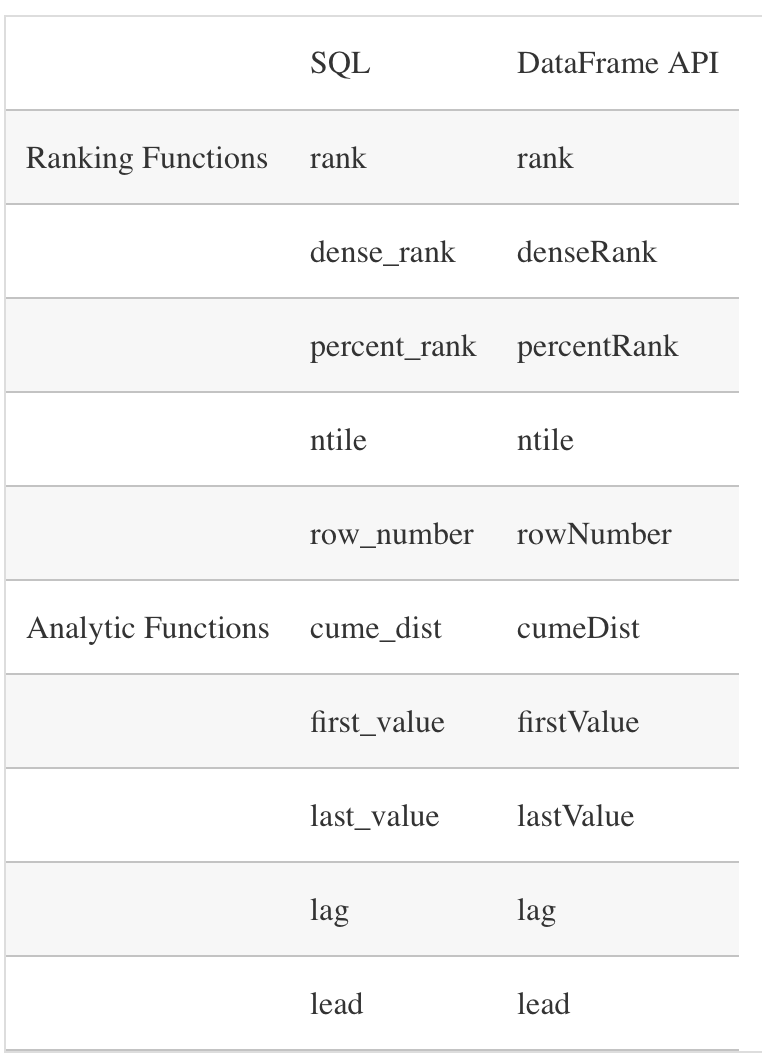